In [1]:
import pathlib
import re

In [2]:
class RunResult:
    Serial="Serial"
    OpenMP="OpenMP"
    MPI="MPI"
    
    def __init__(self, name, millis, procCnt, runType, nodeCnt=None):
        self.name = name
        self.millis = millis
        self.procCnt = procCnt
        self.nodeCnt = nodeCnt
        self.runType = runType
            
        
    def __str__(self):
        return f"""
        {self.name} ({self.runType})\n
        \tDuration [ms]: {self.millis}\n
        \tproc: {self.procCnt}\n
        \tnode: {self.nodeCnt}\n
        """
class BaseParser:
    
    @staticmethod 
    def parseStdout(stdout):
        with open(stdout) as file:
            data = file.read().splitlines()
            
        millis = None
        for i, line in enumerate(data):
            if re.match(f'^Cena', line):
                millis = int(data[i+1].split()[2])
                break
                
        return millis

# Serial

In [3]:
class SerialParser(BaseParser):
    
    @staticmethod 
    def parseFilename(filename):
        return 1, str(filename)
    
    @staticmethod 
    def parse(path):
        procCnt, name = SerialParser.parseFilename(path.name)
        millis = SerialParser.parseStdout(path / 'stdout')
        return RunResult(name, millis, procCnt, RunResult.Serial)
    

pSerial = pathlib.Path('serial')
serialLst = []
for p in pSerial.glob('*'):
    serialLst.append(SerialParser.parse(p))
    
serialKilled = set([x.name+'-p'+str(x.procCnt) for x in serialLst if x.millis is None])
print(f'Killed {serialKilled}')

Killed {'saj6-p1'}


# OpenMP

In [4]:
class OpenMpParser(BaseParser):
    
    @staticmethod 
    def parseFilename(filename):
        sp = str(filename).split('-')
        name = sp[0]
        procCnt = int(sp[1][1:])
        return procCnt, name
    
    @staticmethod 
    def parse(path, runType=None):
        runType = runType or RunResult.OpenMP
        procCnt, name = OpenMpParser.parseFilename(path.name)
        millis = OpenMpParser.parseStdout(path / 'stdout')
        return RunResult(name, millis, procCnt, runType)

## Task parallelism

In [5]:
pTaskPar = pathlib.Path('openmp/task-par/out')
taskParLst = []
for p in pTaskPar.glob('*'):
    taskParLst.append(OpenMpParser.parse(p, runType="openmp-task"))
    
taskKilled = set([ x.name+'-p'+str(x.procCnt) for x in taskParLst if x.millis is None])
print(f'Killed {taskKilled}')

Killed {'saj12-p16', 'saj12-p2'}


## Task parallelism [threshold]

In [6]:
taskParDict = dict.fromkeys([2, 4, 6, 8, 10, 12])

for t in taskParDict.keys():
    tmp = []
    for p in pathlib.Path(f'openmp/task-par-threshold/out-t{t}').glob('*'):
        tmp.append(OpenMpParser.parse(p, runType="openmp-task-threshold"))
    taskParDict[t] = tmp
    
print('threshold | killed')
for t in taskParDict.keys():
    print(f'\t{t}: {len([x for x in taskParDict[t] if x.millis is not None])}')

threshold | killed
	2: 13
	4: 6
	6: 18
	8: 11
	10: 12
	12: 9


## Data parallelism 

In [7]:
pDataPar = pathlib.Path('openmp/data-par/out0')
dataParLst = []
for p in pDataPar.glob('*'):
    dataParLst.append(OpenMpParser.parse(p, runType="openmp-data"))

dataKilled = set([x.name+'-p'+str(x.procCnt) for x in dataParLst if x.millis is None])
print(f'Killed {dataKilled}')

Killed set()


# MPI

In [8]:
line = "0: Elapsed time is 47.276555."
re.findall(r'\d+.\d+', line)

['47.276555']

In [9]:
class MpiParser(BaseParser):
    
    @staticmethod 
    def parseStdout(stdout):
        with open(stdout) as file:
            data = file.read().splitlines()
            
        millis = None
        for i, line in enumerate(data):
            if re.match(f'^0: Elapsed time is', line):
                millis = int(float(re.findall(r'\d+.\d+', line)[0]) * 1000)
                break
                
        return millis
    
    @staticmethod 
    def parseFilename(filename):
        sp = str(filename).split('-')
        name = sp[0]
        nodeCnt = int(sp[1][1:])
        procCnt = int(sp[2][1:])
        return procCnt, name, nodeCnt
    
    @staticmethod 
    def parse(path):
        procCnt, name, nodeCnt = MpiParser.parseFilename(path.name)
        millis = MpiParser.parseStdout(path / 'stdout')
        return RunResult(name, millis, procCnt, RunResult.MPI, nodeCnt)

In [10]:
mpiLst = []
for p in pathlib.Path('mpi/out0').glob('*'):
    mpiLst.append(MpiParser.parse(p))
    
taskKilled = set([ x.name+'-n'+str(x.nodeCnt)+'-p'+str(x.procCnt) for x in mpiLst if x.millis is None])
taskAlive = set([ x.name+'-p'+str(x.procCnt) for x in mpiLst if x.millis is not None])
print("killed", len(taskKilled), taskKilled, "\n")
print("computed", len(taskAlive), taskAlive)

killed 0 set() 

computed 15 {'saj12-p20', 'saj12-p6', 'saj10-p8', 'saj12-p8', 'saj7-p6', 'saj7-p20', 'saj7-p12', 'saj7-p8', 'saj10-p12', 'saj12-p12', 'saj10-p6', 'saj12-p16', 'saj7-p16', 'saj10-p16', 'saj10-p20'}


# Graphing results

Měřené instance jsou 7, 10, 12.

## Create dataframe

In [11]:
m = ['saj7', 'saj10', 'saj12']
ser = [x for x in serialLst if x.name in m ]
mpt = [x for x in taskParLst if x.name in m ]
mpd = [x for x in dataParLst if x.name in m ]
mpi = [x for x in mpiLst if x.name in m ]

In [12]:
import pandas as pd

def runResultToList(r):
    return r.runType.lower(), r.name, r.millis, r.procCnt, r.nodeCnt
    
lst = []
for r in [item for x in [ser, mpt, mpd, mpi] for item in x]:
    lst.append(runResultToList(r))
df = pd.DataFrame(lst, columns=['type', 'instance', 'millis', 'proc', 'node'])
df["minuty"] = df["millis"] / (1000*60)
display(df)

,type,instance,millis,proc,node,minuty
0,serial,saj10,103666.0,1,NaN,1.727767
1,serial,saj12,489801.0,1,NaN,8.163350
2,serial,saj7,272536.0,1,NaN,4.542267
3,openmp-task,saj10,131979.0,1,NaN,2.199650
4,openmp-task,saj10,64735.0,10,NaN,1.078917
...,...,...,...,...,...,...
76,mpi,saj7,72642.0,12,4.0,1.210700
77,mpi,saj7,68517.0,16,4.0,1.141950
78,mpi,saj7,72602.0,20,4.0,1.210033
79,mpi,saj7,97800.0,6,4.0,1.630000


## Plot

### 1. Porovnani nejvykonnejsich

In [13]:
dfCmp = df[
    (df.type == "serial") |
    ((df.type == "openmp-data") & (df.proc == 20)) |
    (df.proc == 20) & (df.node == 4)
].sort_values(by=["instance", "type"], ascending=[False, False]).reset_index(drop=True)
display(dfCmp)

,type,instance,millis,proc,node,minuty
0,serial,saj7,272536.0,1,NaN,4.542267
1,openmp-data,saj7,299.0,20,NaN,0.004983
2,mpi,saj7,72602.0,20,4.0,1.210033
3,serial,saj12,489801.0,1,NaN,8.163350
4,openmp-data,saj12,539183.0,20,NaN,8.986383
5,mpi,saj12,170979.0,20,4.0,2.849650
6,serial,saj10,103666.0,1,NaN,1.727767
7,openmp-data,saj10,82080.0,20,NaN,1.368000
8,mpi,saj10,31288.0,20,4.0,0.521467


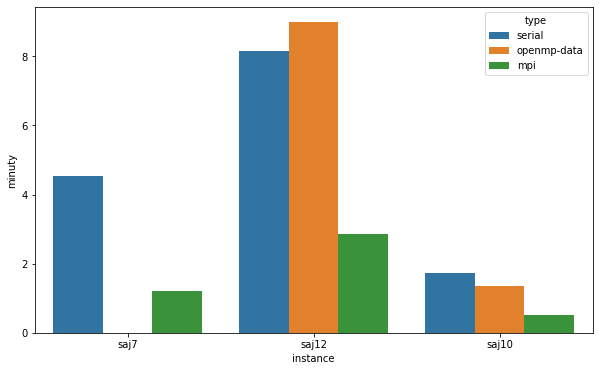

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

xticks = ['saj7', 'saj10', 'saj12']
yticks = [dfCmp.millis[3*k:3*k+3].tolist() for k in range(3)]
labels = ["sekvenční", "OpenMP data, p=20", "MPI+OpenMP data, p=20, uzly=4"]

f = plt.figure(figsize=(10, 6))
sns.barplot(x="instance", hue="type", y="minuty", data=dfCmp)
plt.show()
f.savefig("img/porovnani-nejvykonnejsich.pdf", bbox_inches='tight')

In [15]:
###

In [16]:
# r = df[df.type == 'serial'].to_latex(
#     columns=["instance", "minuty"],
#     caption="Výsledky měření sekvenčního algoritmu.",
#     label="tab:seq",
#     index=False,
#     float_format="%.2f"
# )
# print(r)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   type      81 non-null     object 
 1   instance  81 non-null     object 
 2   millis    79 non-null     float64
 3   proc      81 non-null     int64  
 4   node      30 non-null     float64
 5   minuty    79 non-null     float64
dtypes: float64(3), int64(1), object(2)
memory usage: 3.9+ KB


In [17]:
# display(df[df.type == 'mpi'].sort_values(by=['instance', 'proc', 'node']))
# print(len(df[df.type == 'mpi'].sort_values(by=['instance', 'proc', 'node'])))
# df.type.unique()

In [79]:
df

,type,instance,millis,proc,node,minuty,millisSU,parSpeedUp
21,openmp-task,saj7,248.0,16,NaN,0.004133,272536.0,1098.935484
47,openmp-data,saj7,299.0,20,NaN,0.004983,272536.0,911.491639
44,openmp-data,saj7,346.0,10,NaN,0.005767,272536.0,787.676301
23,openmp-task,saj7,397.0,20,NaN,0.006617,272536.0,686.488665
45,openmp-data,saj7,423.0,16,NaN,0.007050,272536.0,644.293144
...,...,...,...,...,...,...,...,...
3,openmp-task,saj10,131979.0,1,NaN,2.199650,103666.0,0.785473
30,openmp-data,saj10,176881.0,2,NaN,2.948017,103666.0,0.586078
6,openmp-task,saj10,199301.0,2,NaN,3.321683,103666.0,0.520148
13,openmp-task,saj12,NaN,16,NaN,NaN,489801.0,NaN


# Výpočet zrychlení

In [107]:
saj7_SU = float(df[(df['type'] == 'serial') & (df['instance'] == 'saj7')].millis)
saj10_SU = float(df[(df['type'] == 'serial') & (df['instance'] == 'saj10')].millis)
saj12_SU = float(df[(df['type'] == 'serial') & (df['instance'] == 'saj12')].millis)

def calculateParSpeedUp(row):
    if row.instance == 'saj7':
        return saj7_SU / row.millis
    if row.instance == 'saj10':
        return saj10_SU / row.millis
    if row.instance == 'saj12':
        return saj12_SU / row.millis
    
def addSU(x):
    if x == 'saj7':
        return saj7_SU
    if x == 'saj10':
        return saj10_SU
    if x == 'saj12':
        return saj12_SU
    
def calculateParCena(x):
    m = 1
    if not np.isnan(x.node):
        m = x.node
    return x.proc*m*x.millis
    
    
    
df['millisSU'] = df.instance.apply(lambda x: addSU(x))
df['parSpeedUp'] = df.apply(lambda x: calculateParSpeedUp(x), axis=1)
df['parCenaMillis'] = df.apply(lambda x: calculateParCena(x), axis=1)
df['efektivita'] = df['millisSU'] / df['parCenaMillis']
df = df.sort_values(by='parSpeedUp', ascending=False)

In [109]:
df.type.unique()

array(['openmp-task', 'openmp-data', 'mpi', 'serial'], dtype=object)

In [127]:
lst = df[(df.type == 'openmp-data') & (df.instance == 'saj12')].sort_values(by=['instance', 'proc']).reset_index().efektivita
for x in lst:
    print(f'{x:0.3f}', end='\t')

0.849	0.496	0.295	0.231	0.159	0.122	0.107	0.045	

In [131]:
for x in df[(df.type == 'mpi') & (df.instance == 'saj12')].sort_values(by=['proc', 'node'], ascending=[True, True]).efektivita.tolist():
    print(f'{x:0.3f}', end='\t')

0.110	0.095	0.100	0.084	0.069	0.064	0.056	0.046	0.050	0.036	